# Testing the optimization run for convergence:

In [7]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.factory import get_performance_indicator # Used to calculate hypervolume from archivelogged solutions

## Epsilon progress:

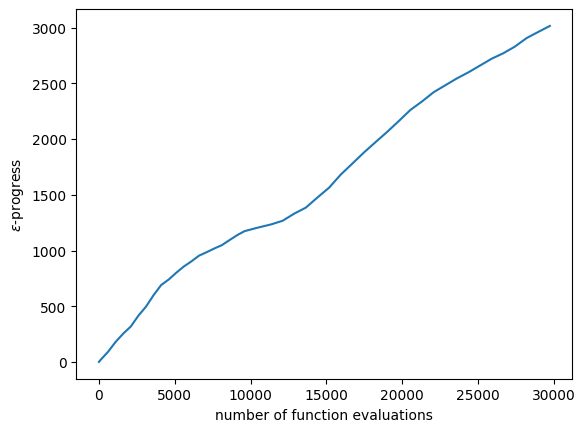

In [8]:
# Epsilon progress is already saved during the optimization
convergence = pd.read_csv("../outputs/baseline_convergence.csv")

fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("$\epsilon$-progress")
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

## Hypervolume:

Let's find the best and worst possible results for all objectives (to normalize them within 0-1 interval) except Sudan's 90th percentile worst month (as it is always 0). I will determine the best and worst possible values for each objective among all the archivelogged sets as well as the final pareto-front:

In [9]:
obj_indexes = [-6,-5,-4,-3,-1] # To get rid of Sudan objectives
directions = ["min", "min", "min", "min", "max"] # Only GERD Hydropower is a maximization objective
best = [1e9,1e9,1e9,1e9,0] # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0,0,0,0,1e10] # Same idea, initialize the worst as something very good

csvs_to_read = [f"../outputs/archive_logs/archive_{i}.csv" for i in range(2,47)]
csvs_to_read.append("../outputs/baseline_results.csv") # All archived solutions + final set

for file in csvs_to_read:
    current_df = pd.read_csv(file).iloc[:, obj_indexes]
    for i, col in enumerate(current_df.columns):
        # Updating the bests and worsts by looking at each solution:
        if directions[i] == "min":
            if current_df[col].max() > worst[i]: worst[i] = current_df[col].max()
            if current_df[col].min() < best[i]: best[i] = current_df[col].min()
        if directions[i] == "max":
            if current_df[col].max() > best[i]: best[i] = current_df[col].max()
            if current_df[col].min() < worst[i]: worst[i] = current_df[col].min()

In [10]:
print(best)
print(worst)

[16357.346498364082, 65.76511323859177, 0.0, 0.0, 32511543.54994061]
[72602.65800965152, 1115.7603391125356, 0.9333333333333332, 3535.8295224402045, 0.0]


In [11]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])
        
    return np.array(df)
            

In [12]:
# Let's calculate hypervolume per NFE to plot
hvs = np.empty(0)
nfes = np.empty(0)
hv = get_performance_indicator("hv", ref_point=np.array([1.2, 1.2, 1.2, 1.2, 1.2])) # Reference set, works fine since everything is btwn 0-1

for i in range(2,47): # We have that 82 archive logs, first doesn't have a solution
    
    nfes = np.append(nfes, 500*i) # Convergence check frequency is 500 NFEs
    print(i, "I am here NFE")
    hvs = np.append(hvs, (hv.do(normalize_objs( # Read and normalize data frames with 5 objectives
        pd.read_csv(f"../outputs/archive_logs/archive_{i}.csv").iloc[:, obj_indexes],
                                worst,
                                best
                               ))))
    print(i, "I am here HV")

2 I am here NFE
2 I am here HV
3 I am here NFE
3 I am here HV
4 I am here NFE
4 I am here HV
5 I am here NFE
5 I am here HV
6 I am here NFE
6 I am here HV
7 I am here NFE
7 I am here HV
8 I am here NFE
8 I am here HV
9 I am here NFE
9 I am here HV
10 I am here NFE
10 I am here HV
11 I am here NFE
11 I am here HV
12 I am here NFE
12 I am here HV
13 I am here NFE
13 I am here HV
14 I am here NFE
14 I am here HV
15 I am here NFE
15 I am here HV
16 I am here NFE
16 I am here HV
17 I am here NFE
17 I am here HV
18 I am here NFE
18 I am here HV
19 I am here NFE
19 I am here HV
20 I am here NFE
20 I am here HV
21 I am here NFE
21 I am here HV
22 I am here NFE
22 I am here HV
23 I am here NFE
23 I am here HV
24 I am here NFE
24 I am here HV
25 I am here NFE
25 I am here HV
26 I am here NFE
26 I am here HV
27 I am here NFE
27 I am here HV
28 I am here NFE
28 I am here HV
29 I am here NFE
29 I am here HV
30 I am here NFE
30 I am here HV
31 I am here NFE
31 I am here HV
32 I am here NFE
32 I am h

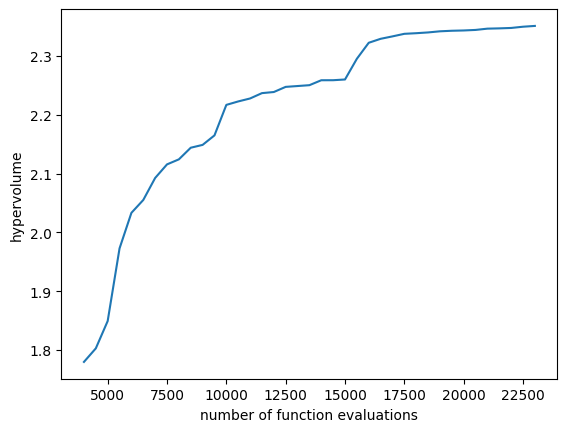

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("hypervolume")
ax.plot(nfes[6:], hvs[6:]) # First 6 distorts the view, giving a wrong sense of convergence
plt.show()

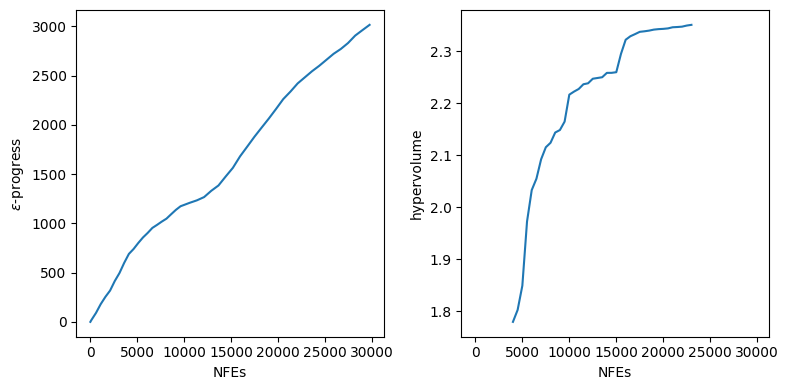

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress")
ax2.plot(nfes[6:], hvs[6:])
ax2.set_ylabel("hypervolume")

ax1.set_xlabel("NFEs")
ax2.set_xlabel("NFEs")
fig.tight_layout()
plt.show()

Interestingly epsilon progress suggests there is room for improvement however hypervolume hints at the opposite with **50,000** NFEs!